In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import os
import argparse
import json

import torch
from torchvision.transforms import Normalize
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models.base_unet import BaseUNet
from src.models.unet_pp import UNetPlus
from src.models.hr_spin import HRSPIN
from src.utils.visualizations import plot_predictions
from src.utils.io import load_image, save_mask
from src.scripts.mask_to_submission import masks_to_submission

In [3]:
DEVICE = "mps"

In [4]:
models = os.listdir("../logs")

scores = []
for dir in models:
    if not os.path.exists(f"../logs/{dir}/metrics.json"):
        continue
    metrics = json.load(open(f"../logs/{dir}/metrics.json", "r"))
    args = argparse.Namespace(**json.load(open(f"../logs/{dir}/config.json", "r")))
    scores.append((dir, args.model, max(metrics['val_acc'])))

threshold = 0.93
count = np.sum([1 for score in scores if score[-1] > threshold])
print(f"Number of models with score > {threshold}: {count}")
print()

scores.sort(key=lambda x: x[-1], reverse=True)
for score in scores:
    print(score)


Number of models with score > 0.93: 6

('2023-07-20_14-53-19', 'spin', 0.9348375499248505)
('2023-07-23_14-04-44', 'spin', 0.9338871985673904)
('2023-07-20_10-16-04', 'spin', 0.9313459396362305)
('2023-07-22_10-09-37', 'spin', 0.9303366392850876)
('2023-07-24_10-53-13', 'spin', 0.9303316622972488)
('2023-07-19_01-39-33', 'unet++', 0.9300405234098434)
('2023-07-20_18-20-02', 'spin', 0.929843544960022)
('2023-07-19_01-00-06', 'unet++', 0.9284140765666962)
('2023-07-24_07-25-00', 'unet++', 0.9278751611709595)
('2023-07-18_18-05-55', 'unet', 0.9262954443693161)
('2023-07-19_05-13-07', 'unet++', 0.9261408001184464)
('2023-07-19_11-07-31', 'unet', 0.9252951294183731)
('2023-07-19_09-20-50', 'unet++', 0.9247572869062424)
('2023-07-19_11-41-04', 'unet++', 0.924745723605156)
('2023-07-18_17-26-08', 'unet++', 0.9245528727769852)
('2023-07-19_10-33-56', 'unet', 0.9245344698429108)
('2023-07-18_21-13-39', 'unet++', 0.9241626709699631)
('2023-07-19_05-52-19', 'unet++', 0.9238899946212769)
('2023-07

In [5]:
N = 6

checkpoints = [f"../logs/{score[0]}" for score in scores[:N]]

In [6]:
metadata = "../metadata.json"

metadata = json.load(open(metadata, "r"))

In [7]:
def load_model(checkpoint, mode="best"):
    with open(os.path.join(checkpoint, "config.json"), "r") as f:
        vars = json.load(f)
    args = argparse.Namespace(**vars)

    chs = [3] + [2 ** (i + 5) for i in range(args.depth)]
    if args.model == "unet":
        model = BaseUNet(chs)
    elif args.model == "unet++":
        model = UNetPlus(chs)
    elif args.model == "spin":
        model = HRSPIN(num_stacks=args.num_stacks)
    else:
        raise ValueError("Invalid model name")
    
    if mode == "last" and os.path.exists(os.path.join(checkpoint, "last_model.pt")):
        model.load_state_dict(torch.load(os.path.join(checkpoint, "last_model.pt"), map_location=torch.device("cpu")))
    else:
        model.load_state_dict(torch.load(os.path.join(checkpoint, "best_model.pt"), map_location=torch.device("cpu")))

    return model, args

# Get test images

In [8]:
test_images = "../data/test/images/"

fnames = os.listdir(test_images)
fnames = [os.path.join(test_images, fname) for fname in fnames if fname.endswith(".png")]

len(fnames)

144

# Predict test images

In [9]:
def predict_mask(path, checkpoints):
    mean = metadata["cil"]["img_mean"]
    std = metadata["cil"]["img_std"]

    transform = Normalize(mean=mean, std=std)

    image = load_image(path)
    image = torch.tensor(image)
    image = image.permute(2, 0, 1).unsqueeze(0).float()
    image = transform(image)

    preds = []
    for ckpt in checkpoints:
        model, args = load_model(ckpt)

        model.eval()
        model.to(DEVICE)
        with torch.no_grad():
            if args.model == "spin":
                prediction, _ = model(image.to(DEVICE))
                prediction = prediction[-1].squeeze(0)
            else:
                prediction = model(image.to(DEVICE)).squeeze(0)

            preds.append(prediction.cpu())

        # Load last model if it exists
        if os.path.exists(os.path.join(ckpt, "last_model.pt")):
            model, args = load_model(ckpt, mode="last")

            model.eval()
            model.to(DEVICE)
            with torch.no_grad():
                if args.model == "spin":
                    prediction, _ = model(image.to(DEVICE))
                    prediction = prediction[-1].squeeze(0)
                else:
                    prediction = model(image.to(DEVICE)).squeeze(0)

                preds.append(prediction.cpu())

    return torch.stack(preds).mean(0)

predictions = torch.stack([predict_mask(fname, checkpoints) for fname in tqdm(fnames)])
predictions.shape

100%|██████████| 144/144 [06:50<00:00,  2.85s/it]


torch.Size([144, 400, 400])

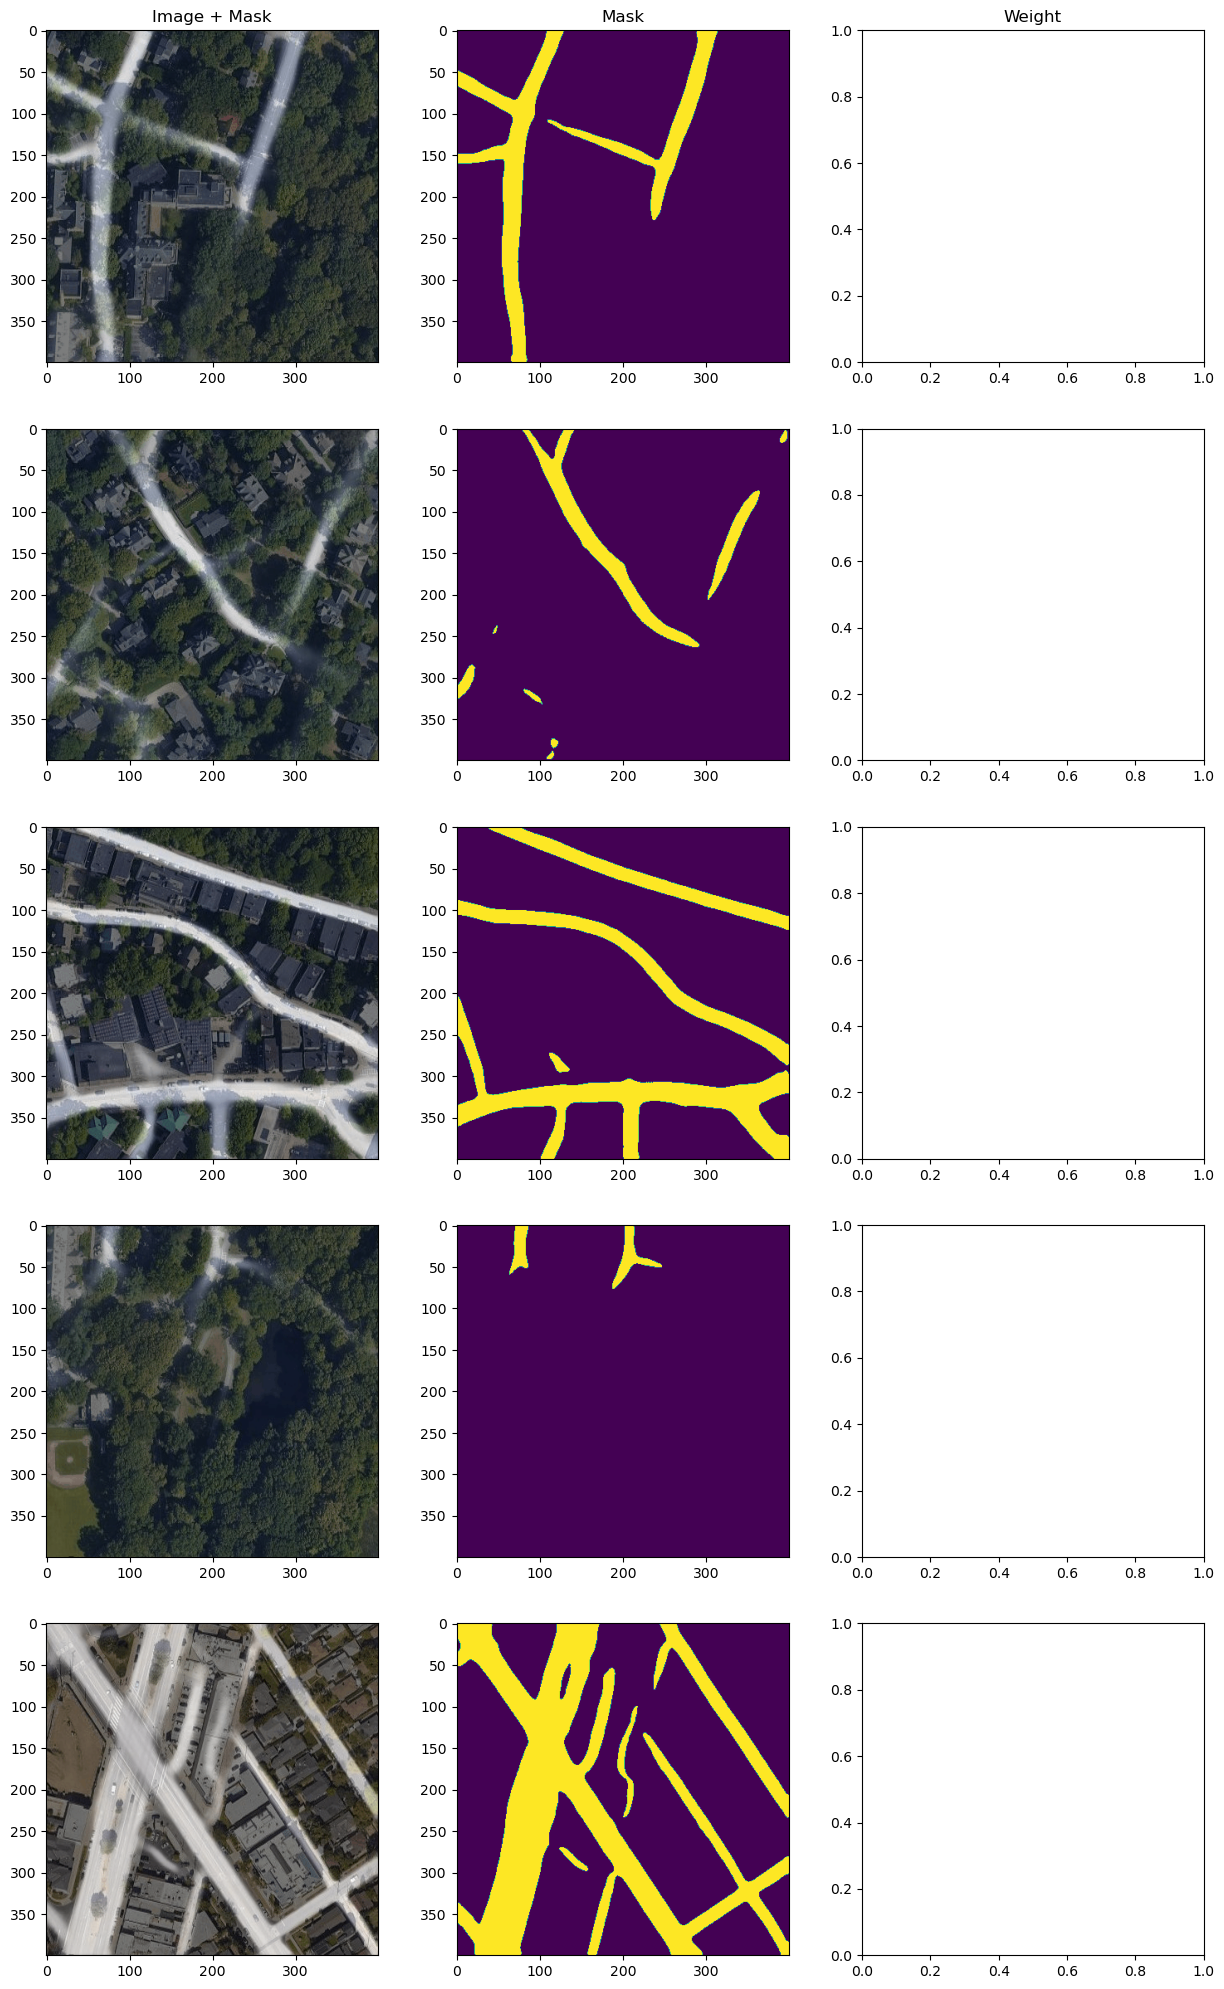

In [10]:
N = 5

images = [torch.tensor(load_image(fname)) for fname in fnames[:N]]
masks = [torch.zeros_like(image) for image in predictions[:N]]
weights = [torch.zeros_like(image) for image in predictions[:N]]

images = torch.stack(images)
masks = torch.stack(masks)
weights = torch.stack(weights)

plot_predictions(
    images=images,
    masks=masks,
    predictions=predictions[:N],
    # weights=predictions[:N] > .5,
)

# Save masks

In [11]:
pred_path = "../data/preds/"

for fname, prediction in tqdm(zip(fnames, predictions), total=len(fnames), ncols=80):
    out_fname = os.path.join(pred_path, os.path.basename(fname))
    prediction = prediction.numpy() > 0.5
    prediction = prediction.astype(np.uint8) * 255
    prediction = np.stack([prediction, prediction, prediction], axis=-1)
    save_mask(prediction, out_fname)

100%|████████████████████████████████████████| 144/144 [00:00<00:00, 314.57it/s]


# Create submission file

In [12]:
fnames = os.listdir(pred_path)
fnames = [os.path.join(pred_path, fname) for fname in fnames if fname.endswith(".png")]

In [13]:
masks_to_submission(
    "../data/submission.csv",
    "",
    *sorted(fnames),
)

# Expected grade

In [15]:
our_score = 0.91973

max_score = 0.94251
baseline_score = 0.86380

4 + 2 * (our_score - baseline_score) / (max_score - baseline_score)

5.421166306695467